In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import math


from qiskit import QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import StatevectorEstimator, BackendEstimatorV2 as BackendEstimator
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator


In [2]:
#Rendiamo generale la funzione, prende N numero di Spin, t il tempo, j il primo spin e i il secondo spin (questi saranno j e j+1 in quanto nearest neighbours)
def R_zz(N, t, j, i):
    
    ZZ_qc = QuantumCircuit(N)

    ZZ_qc.cx(j,i)
    ZZ_qc.rz(2 * t, i) #vedi definizione sopracitata per il fattore 2
    ZZ_qc.cx(j,i)

    return ZZ_qc

#decomponiamo il Rot. Gate XX
def R_xx(N, t, j, i):

    XX_qc = QuantumCircuit(N)

    XX_qc.ry(np.pi/2,[j,i])
    XX_qc.cx(j,i)
    XX_qc.rz(2 * t, i)
    XX_qc.cx(j,i)
    XX_qc.ry(-np.pi/2,[j,i])

    return XX_qc

#decomponiamo il Rot. Gate YY
def R_yy(N, t, j, i):
    YY_qc = QuantumCircuit(N)
    
    YY_qc.rx(np.pi/2,[j,i])
    YY_qc.cx(j,i)
    YY_qc.rz(2 * t, i)
    YY_qc.cx(j,i)
    YY_qc.rx(-np.pi/2,[j,i])

    return YY_qc


#definiamo l'hamiltoniana
def H_Heis(N):
    #usiamo J = 1
    XX_tuples = [("XX", [i, i + 1], 1) for i in range(0, N-1)]
    YY_tuples = [("YY", [i, i + 1], 1) for i in range(0, N-1)]
    ZZ_tuples = [("ZZ", [i, i + 1], 1) for i in range(0, N-1)]

    #col metodo from_sparse_list di SparsePauliOp definiamo l'hamiltoniana
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples, *ZZ_tuples], N)

    return hamiltonian

#definiamo l'evoluzione temporale nel caso classico
def U_Heis(n_spins,t):
    H = H_Heis(n_spins).to_matrix()
    return la.expm(-1j*t*H)

def Heisenberg_Trotter(num_spins, trotter_steps, t):
    #definiamo un time step dt
    dt = (t)/(trotter_steps) 

    #creiamo il quantumcircuit
    qc_t = QuantumCircuit(num_spins)

    #iteriamo su ogni time step
    for i in range(trotter_steps):
        #iteriamo su ogni spin
        for j in range(0, num_spins -1):
            #implementazione dei gate è uguale al caso precedente, in quanto operiamo su coppie di spin
            qc_t = qc_t.compose(R_xx(num_spins,dt,j,j+1))
            qc_t = qc_t.compose(R_yy(num_spins,dt,j,j+1))
            qc_t = qc_t.compose(R_zz(num_spins,dt,j,j+1))

        
        #qc.barrier()

    return qc_t

In [3]:
#creazione del NoiseModel e del pm
from qiskit_ibm_runtime.fake_provider import FakeMontrealV2

QiskitRuntimeService.save_account(channel="ibm_quantum", token="982082508a1c98ca02cb712c6751b42ef860d905b080b3bfc02ef35d68d84441803586912cbcf181e1e72ebc8569103421b06c25408fe8134975a72575c4d637", overwrite= True)

#FakeManila è datato, utilizziamo FakeMontrealV2
fake_backend = FakeMontrealV2()

In [21]:
#La curva esatta

et_steps = 100 #la curva esatta deve essere accurata
#definiamo il tempo in cui facciamo evolvere il sistema
dt = 3

#generiamo una spaziatura lineare di t_steps nell'intervallo [0, 3]
et_ts = np.linspace(0, dt, et_steps) 
#011
initial_state = Statevector.from_label('011').data
probs_110 = [np.abs((initial_state @ U_Heis(3,float(t)) @ initial_state))**2 for t in et_ts]

In [23]:
#definiamo il numero di time steps, creiamo ts e definiamo "prj"
t_steps = 12 
#definiamo il tempo in cui facciamo evolvere il sistema
dt = 3
ts = np.linspace(0, dt, t_steps) 

#misuriamo |110><110|
prj_zero = SparsePauliOp.from_list([("I", 1/2), ("Z", 1/2)])
prj_one = SparsePauliOp.from_list([("I", 1/2), ("Z", -1/2)])
prj = prj_one ^ prj_one ^ prj_zero


In [24]:
#definiamo il numero di time steps, creiamo ts e definiamo "prj"
trott_steps = 12 
#definiamo il tempo in cui facciamo evolvere il sistema
dt = 3
ts = np.linspace(0, dt, trott_steps) 

In [25]:
#facciamo andare il circuito con 12 trotter step senza error mitigation
probs_trotter = []
pm_trotter = generate_preset_pass_manager(optimization_level=2, backend=fake_backend)

for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato "110"
    qc.x(1)
    qc.x(2)
        
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=t_steps,t=sim_t)
    qc = qc.compose(trott_steps)
    
    isa_circuit = pm_trotter.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    estimator       = BackendEstimator(backend=fake_backend)
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    probs_trotter.append(trotter_value.mean().real)

    
print("12 steps trotter completed")

12 steps trotter completed


In [63]:
number = 1
file_value = open("qpu_values.txt", "w")
file_value.write('DATI SIMULAZIONE ' + str(number) +  ' SU QPU:\n') 

27

In [27]:
service = QiskitRuntimeService()
qpu_backend = service.least_busy(operational=True, simulator=False, min_num_qubits=27)
qpu_pm = generate_preset_pass_manager(optimization_level=2, backend=qpu_backend)
qpu_estimator = Estimator(qpu_backend)

In [19]:
qpu_probs = []
qpu_t = np.linspace(0, dt, 12)
for sim_t in qpu_t:
    qc = QuantumCircuit(3)
    #buildiamo lo stato "110"
    qc.x(1)
    qc.x(2)
        
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=12,t=sim_t)
    qc = qc.compose(trott_steps)

    #effettuiamo la transpile in locale e mandiamo su IBM
    isa_circuit = qpu_pm.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    qpu_trotter_result = qpu_estimator.run([(isa_circuit, isa_observable)]).result()
    qpu_trotter_value = qpu_trotter_result[0].data.evs
    qpu_probs.append(qpu_trotter_value.mean().real)

    print('tempo = ' + str(sim_t) + ' completato')


print('finished')

tempo = 0.0 completato
tempo = 0.2727272727272727 completato
tempo = 0.5454545454545454 completato
tempo = 0.8181818181818181 completato
tempo = 1.0909090909090908 completato
tempo = 1.3636363636363635 completato
tempo = 1.6363636363636362 completato
tempo = 1.909090909090909 completato
tempo = 2.1818181818181817 completato
tempo = 2.454545454545454 completato
tempo = 2.727272727272727 completato
tempo = 3.0 completato
finished


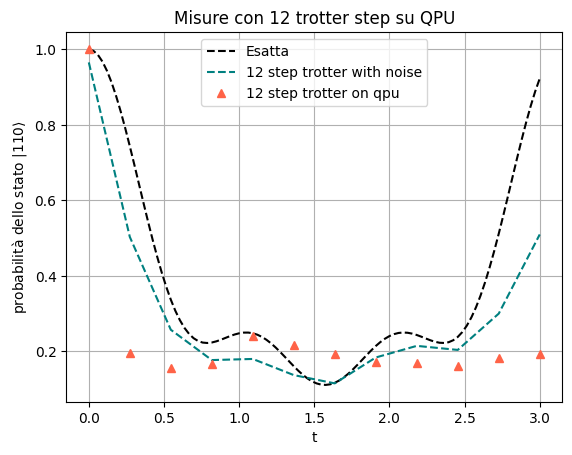

[np.float64(1.0012821677511148), np.float64(0.1958750828063676), np.float64(0.15532328232709844), np.float64(0.16765601770839914), np.float64(0.2413956619959367), np.float64(0.21609199693082817), np.float64(0.19268200834609378), np.float64(0.17186527268761492), np.float64(0.16930966516739204), np.float64(0.16104565951170377), np.float64(0.1815952886563098), np.float64(0.19189558816884028)]


In [26]:
#ibm sherbrooke 127 qubit
plt.plot(et_ts, probs_110,linestyle="dashed",color="black",label="Esatta")
plt.plot(ts, probs_trotter,color="teal",linestyle="dashed",label="12 step trotter with noise")
plt.plot(qpu_t, qpu_probs,'^', color="tomato", label="12 step trotter on qpu")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Misure con 12 trotter step su QPU')
plt.legend()
plt.grid()
plt.savefig('../png/qpu1.png')
plt.show()
print(str(qpu_probs))

In [30]:
qpu_probs2 = []
qpu_t2 = np.linspace(0, dt, 12)
for sim_t in qpu_t2:
    qc = QuantumCircuit(3)
    #buildiamo lo stato "110"
    qc.x(1)
    qc.x(2)
        
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=12,t=sim_t)
    qc = qc.compose(trott_steps)

    #effettuiamo la transpile in locale e mandiamo su IBM
    isa_circuit = qpu_pm.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    qpu_trotter_result = qpu_estimator.run([(isa_circuit, isa_observable)]).result()
    qpu_trotter_value = qpu_trotter_result[0].data.evs
    qpu_probs2.append(qpu_trotter_value.mean().real)

    print('tempo = ' + str(sim_t) + ' completato')


print('finished')

tempo = 0.0 completato
tempo = 0.2727272727272727 completato
tempo = 0.5454545454545454 completato
tempo = 0.8181818181818181 completato
tempo = 1.0909090909090908 completato
tempo = 1.3636363636363635 completato
tempo = 1.6363636363636362 completato
tempo = 1.909090909090909 completato
tempo = 2.1818181818181817 completato
tempo = 2.454545454545454 completato
tempo = 2.727272727272727 completato
tempo = 3.0 completato
finished


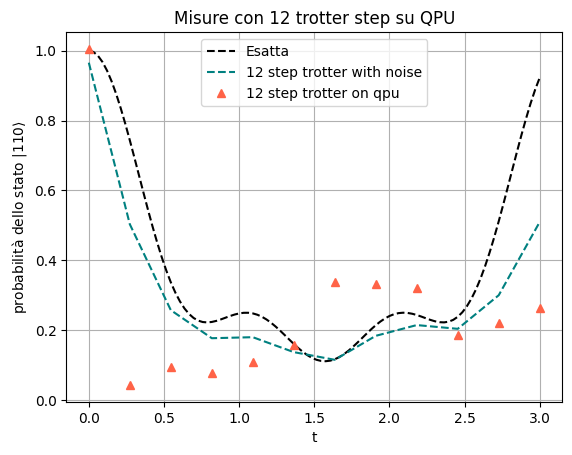

[np.float64(1.0049429285072855), np.float64(0.04332429392684041), np.float64(0.09474239888296833), np.float64(0.07841227426049553), np.float64(0.10912830005103508), np.float64(0.158464799343841), np.float64(0.3365658469871142), np.float64(0.3312310613033131), np.float64(0.32065582967109413), np.float64(0.18738092168974854), np.float64(0.2206074164634913), np.float64(0.26307849569165326)]


In [31]:
#ibm sherbrooke 127 qubit
plt.plot(et_ts, probs_110,linestyle="dashed",color="black",label="Esatta")
plt.plot(ts, probs_trotter,color="teal",linestyle="dashed",label="12 step trotter with noise")
plt.plot(qpu_t2, qpu_probs2,'^', color="tomato", label="12 step trotter on qpu")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Misure con 12 trotter step su QPU')
plt.legend()
plt.grid()
plt.savefig('../png/qpu2.png')
plt.show()

print(str(qpu_probs2))

In [15]:
file_value = open("qpu_values_variable.txt", "w")

In [13]:
service = QiskitRuntimeService()
qpu_backend3 = service.least_busy(operational=True, simulator=False, min_num_qubits=27)
qpu_pm3 = generate_preset_pass_manager(optimization_level=2, backend=qpu_backend3)
qpu_estimator3 = Estimator(qpu_backend3)
#usiamo la tecnica di aumentare i trotter step
qpu_probs3 = []
qpu_t3 = np.linspace(0, dt, 12)
trotter_variable = 1
for sim_t in qpu_t3:
    qc = QuantumCircuit(3)
    #buildiamo lo stato "110"
    qc.x(1)
    qc.x(2)
        
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=trotter_variable,t=sim_t)
    qc = qc.compose(trott_steps)
    print('trotter = ' + str(trotter_variable) + ' completato')
    trotter_variable = trotter_variable + 1

    #effettuiamo la transpile in locale e mandiamo su IBM
    isa_circuit = qpu_pm3.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    qpu_trotter_result = qpu_estimator3.run([(isa_circuit, isa_observable)]).result()
    qpu_trotter_value = qpu_trotter_result[0].data.evs
    qpu_probs3.append(qpu_trotter_value.mean().real)

    print('tempo = ' + str(sim_t) + ' completato')
    
    
    #salviamolo sul file
    file_value.write(str(qpu_trotter_value.mean().real) + '\n')
    
    
print('finished')

trotter = 1 completato
tempo = 0.0 completato
trotter = 2 completato
tempo = 0.2727272727272727 completato
trotter = 3 completato
tempo = 0.5454545454545454 completato
trotter = 4 completato
tempo = 0.8181818181818181 completato
trotter = 5 completato
tempo = 1.0909090909090908 completato
trotter = 6 completato
tempo = 1.3636363636363635 completato
trotter = 7 completato
tempo = 1.6363636363636362 completato
trotter = 8 completato
tempo = 1.909090909090909 completato
trotter = 9 completato
tempo = 2.1818181818181817 completato
trotter = 10 completato
tempo = 2.454545454545454 completato
trotter = 11 completato
tempo = 2.727272727272727 completato
trotter = 12 completato
tempo = 3.0 completato
finished


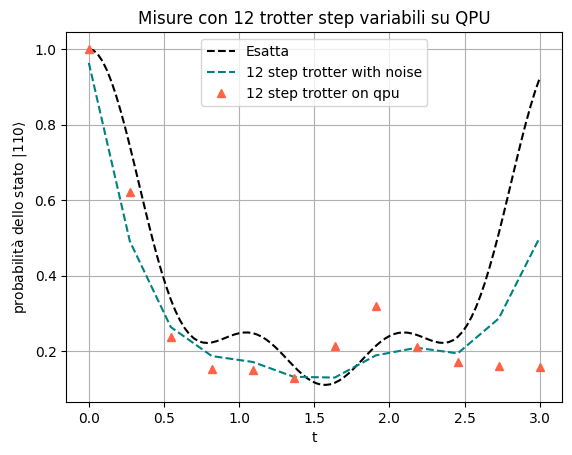

In [14]:
#ibm kiev 127 qubit
plt.plot(et_ts, probs_110,linestyle="dashed",color="black",label="Esatta")
plt.plot(ts, probs_trotter,color="teal",linestyle="dashed",label="12 step trotter with noise")
plt.plot(qpu_t3, qpu_probs3,'^', color="tomato", label="12 step trotter on qpu")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Misure con 12 trotter step variabili su QPU')
plt.legend()
plt.grid()
plt.savefig('../png/qpu3.png')
plt.show()

In [19]:
file_value = open("qpu_values_variable2.txt", "w")

In [6]:
service = QiskitRuntimeService()
qpu_backend3 = service.least_busy(operational=True, simulator=False, min_num_qubits=27)
qpu_pm3 = generate_preset_pass_manager(optimization_level=0, backend=qpu_backend3)
qpu_estimator3 = Estimator(qpu_backend3)
#usiamo la tecnica di aumentare i trotter step
qpu_probs3 = []
qpu_t3 = np.linspace(0, dt, 12)

In [17]:

trotter_variable = 1
for sim_t in qpu_t3:
    qc = QuantumCircuit(3)
    #buildiamo lo stato "110"
    qc.x(1)
    qc.x(2)
        
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=trotter_variable,t=sim_t)
    qc = qc.compose(trott_steps)
    print('trotter = ' + str(trotter_variable) + ' completato')
    trotter_variable = trotter_variable + 1

    #effettuiamo la transpile in locale e mandiamo su IBM
    isa_circuit = qpu_pm3.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    qpu_trotter_result = qpu_estimator3.run([(isa_circuit, isa_observable)]).result()
    qpu_trotter_value = qpu_trotter_result[0].data.evs
    qpu_probs3.append(qpu_trotter_value.mean().real)

    print('tempo = ' + str(sim_t) + ' completato')
    
    
    #salviamolo sul file
    file_value.write(str(qpu_trotter_value.mean().real) + '\n')
    
    
print('finished')

trotter = 1 completato
tempo = 0.0 completato
trotter = 2 completato
tempo = 0.2727272727272727 completato
trotter = 3 completato
tempo = 0.5454545454545454 completato
trotter = 4 completato
tempo = 0.8181818181818181 completato
trotter = 5 completato
tempo = 1.0909090909090908 completato
trotter = 6 completato
tempo = 1.3636363636363635 completato
trotter = 7 completato
tempo = 1.6363636363636362 completato
trotter = 8 completato
tempo = 1.909090909090909 completato
trotter = 9 completato
tempo = 2.1818181818181817 completato
trotter = 10 completato
tempo = 2.454545454545454 completato
trotter = 11 completato
tempo = 2.727272727272727 completato
trotter = 12 completato
tempo = 3.0 completato
finished


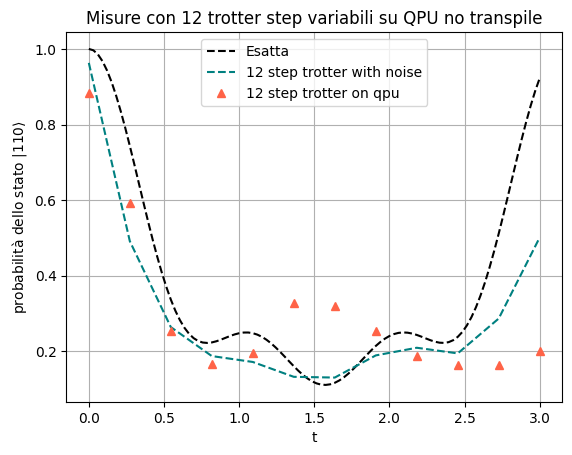

In [18]:
#ibm kiev 127 qubit
plt.plot(et_ts, probs_110,linestyle="dashed",color="black",label="Esatta")
plt.plot(ts, probs_trotter,color="teal",linestyle="dashed",label="12 step trotter with noise")
plt.plot(qpu_t3, qpu_probs3,'^', color="tomato", label="12 step trotter on qpu")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Misure con 12 trotter step variabili su QPU no transpile')
plt.legend()
plt.grid()
plt.savefig('../png/qpu4.png')
plt.show()

In [10]:
# initial_state = Statevector.from_label('011').data
probs_110 = [np.abs((initial_state @ U_Heis(3,float(t)) @ initial_state))**2 for t in qpu_t3]
print(str(probs_110))
print(str(qpu_t3))

[np.float64(1.0), np.float64(0.7435192289777478), np.float64(0.33700735562730255), np.float64(0.22352818353754914), np.float64(0.24801125241057229), np.float64(0.16062797432548337), np.float64(0.11676156252053277), np.float64(0.21419376720075708), np.float64(0.24341192823560653), np.float64(0.2382716069695611), np.float64(0.5117150387707888), np.float64(0.9229565006993241)]
[0.         0.27272727 0.54545455 0.81818182 1.09090909 1.36363636
 1.63636364 1.90909091 2.18181818 2.45454545 2.72727273 3.        ]
